## SALUD

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
dir_input = Path("data/base100/")
ipc_file = dir_input / "base_salud.xlsx"

w_salud = 3.475   # Peso total oficial de la división Salud

In [31]:
df_ipc = pd.read_excel(ipc_file)
df_ipc.columns = df_ipc.columns.str.upper()

categorias = df_ipc["CATEGORIA"].tolist()

print("Categorías detectadas:")
for i, c in enumerate(categorias):
    print(i + 1, c)

Categorías detectadas:
1 ANTICONCEPTIVOS
2 ANTIINFECCIOSOS SISTÉMICOS
3 APARATO CARDIOVASCULAR
4 APARATO DIGESTIVO
5 APARATO GENITOURINARIO Y REPRODUCTOR
6 APARATO RESPIRATORIO
7 OFTALMOLÓGICOS
8 PIEL Y MUCOSAS
9 SANGRE, LÍQUIDOS Y ELECTROLITOS
10 SISTEMA NERVIOSO


In [32]:
pesos_manual = [
    0.016,
    0.159,
    0.137,
    0.107,
    0.065,
    0.182,
    0.058,
    0.085,
    0.024,
    0.237
]

In [33]:
# NORMALIZACIÓN 
suma_original = sum(pesos_manual)
factor = w_salud / suma_original
pesos_norm = [p * factor for p in pesos_manual]

print("\nSuma original:", suma_original)
print("Suma normalizada:", sum(pesos_norm))

df_pesos = pd.DataFrame({
    "CATEGORIA": categorias,
    "PESO": pesos_manual,
    "PESO_NORMALIZADO": pesos_norm
})

display(df_pesos)


Suma original: 1.07
Suma normalizada: 3.475


,CATEGORIA,PESO,PESO_NORMALIZADO
0,ANTICONCEPTIVOS,0.016,0.051963
1,ANTIINFECCIOSOS SISTÉMICOS,0.159,0.516379
2,APARATO CARDIOVASCULAR,0.137,0.444930
3,APARATO DIGESTIVO,0.107,0.347500
4,APARATO GENITOURINARIO Y REPRODUCTOR,0.065,0.211098
5,APARATO RESPIRATORIO,0.182,0.591075
6,OFTALMOLÓGICOS,0.058,0.188364
7,PIEL Y MUCOSAS,0.085,0.276051
8,"SANGRE, LÍQUIDOS Y ELECTROLITOS",0.024,0.077944
9,SISTEMA NERVIOSO,0.237,0.769696


In [34]:
cols_fechas = [c for c in df_ipc.columns if "2025" in c]

w = np.array(pesos_norm)

def geom_pond(x, w):
    x = np.array(x)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

ipc_salud = {}

for col in cols_fechas:
    ipc_salud[col] = geom_pond(df_ipc[col], w)

# Serie final ordenada por fecha
ipc_salud = pd.Series(ipc_salud)
ipc_salud.index = pd.to_datetime(ipc_salud.index)
ipc_salud = ipc_salud.sort_index()

print("\nIPC de la División SALUD:")
display(ipc_salud)


IPC de la División SALUD:


2025-10-29    100.000000
2025-10-30     99.950358
2025-10-31     99.949628
2025-11-01    100.512931
2025-11-02    100.512931
2025-11-03     99.745337
2025-11-04     99.679551
2025-11-05     99.494195
2025-11-06     99.717012
2025-11-07     99.493807
2025-11-08    100.025220
2025-11-09    100.025220
2025-11-10    100.005450
2025-11-11    100.034335
2025-11-12     99.886094
2025-11-13    100.028452
2025-11-14    100.017653
2025-11-15    100.017653
2025-11-16    100.456510
2025-11-17    100.025426
2025-11-18     99.991194
2025-11-19    100.121137
dtype: float64

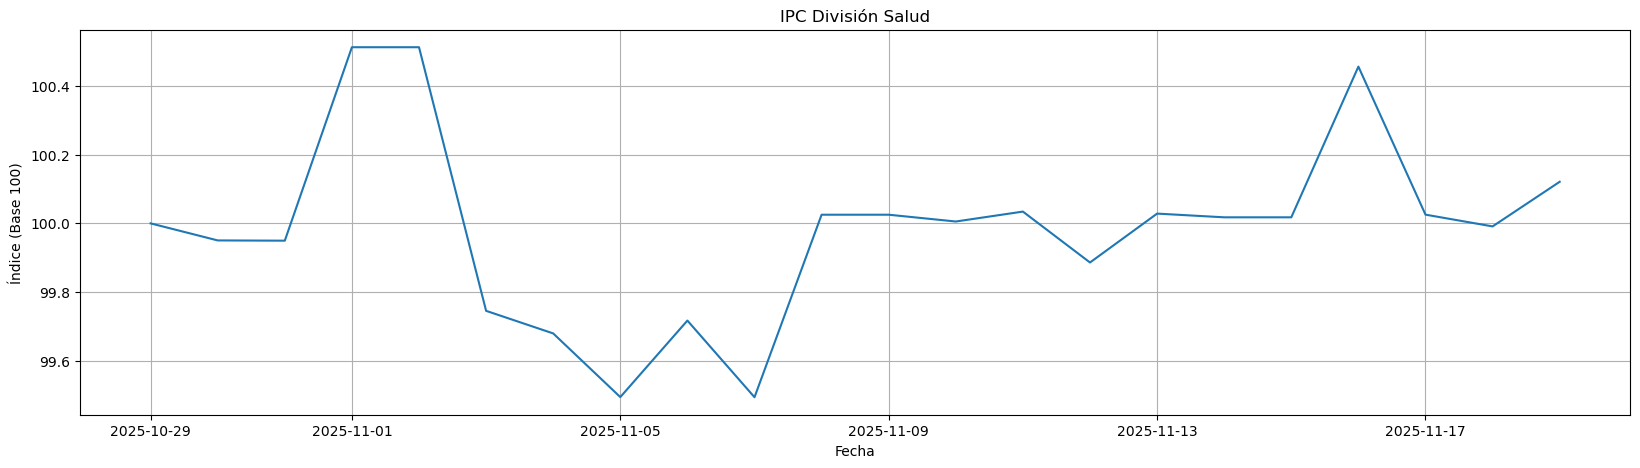

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(ipc_salud.index, ipc_salud.values)
plt.title("IPC División Salud")
plt.xlabel("Fecha")
plt.ylabel("Índice (Base 100)")
plt.grid(True)
plt.show()



fig = go.Figure()

# Línea principal
fig.add_trace(go.Scatter(
    x=daily["FECHA"],
    y=daily["VALOR"],
    mode="lines",
    name="Índice (Base 100)",
    line=dict(width=2)
))


fig.update_layout(
    title=None,#{
    #     'text': "<b>Índice de Combustibles</b><br><span style='font-size:12px;'>Base 100 = 29/10/2025 (Promedio Geométrico)</span>",
    #     'x': 0.5,          # Centrar horizontalmente
    #     'xanchor': 'center',
    #     'yanchor': 'top'
    # },
    xaxis_title="Fecha",
    yaxis_title="Índice (Base 100)",
    template="plotly_white",
    hovermode="x unified",
    width=900,
    height=500
)

fig.show()
fig.write_image("results/indice_salud.pdf")

## ALIMENTOS 

In [36]:
dir_input = Path("data/base100/")
ipc_file = dir_input / "base_alimentos.xlsx"

df_ipc = pd.read_excel(ipc_file)
df_ipc.columns = df_ipc.columns.astype(str)

In [37]:
fecha_cols = []
for c in df_ipc.columns:
    if "2025" in c:
        limpio = c.split(" ")[0]       # quita hora
        fecha_cols.append(limpio)
    else:
        fecha_cols.append(c)

df_ipc.columns = fecha_cols

print("Encabezados limpios:")
print(df_ipc.columns.tolist())

Encabezados limpios:
['subclase_inei', '2025-10-29', '2025-10-30', '2025-10-31', '2025-11-01', '2025-11-02', '2025-11-03', '2025-11-04', '2025-11-05', '2025-11-06', '2025-11-07', '2025-11-08', '2025-11-09', '2025-11-10', '2025-11-11', '2025-11-12', '2025-11-13', '2025-11-14', '2025-11-15', '2025-11-16', '2025-11-17']


In [38]:
# PESOS – ALIMENTOS
subclase_inei = df_ipc["subclase_inei"].tolist()

pesos_alimentos = [
    0.384, 1.373, 0.268, 0.103, 1.210, 0.369, 0.206, 3.070, 1.346,
    0.182, 0.184, 0.192, 0.354, 0.354, 2.425, 0.151, 0.096, 0.255,
    0.619, 0.706, 1.303, 0.022, 0.320, 0.075, 0.322, 0.106, 0.137,
    0.059, 2.134, 0.523, 0.220, 0.211, 0.060, 0.095, 0.316
]

w_alimentos = 23.928  # peso oficial de la división

# Normalizar pesos para que sumen 23.928
suma_original = sum(pesos_alimentos)
factor = w_alimentos / suma_original
pesos_norm = [p * factor for p in pesos_alimentos]

print("\nSuma original:", suma_original)
print("Suma normalizada:", sum(pesos_norm))

w = np.array(pesos_norm)


Suma original: 19.75
Suma normalizada: 23.928


In [39]:
cols_2025 = [c for c in df_ipc.columns if c != "subclase_inei"]

def geom_pond(x, w):
    x = np.array(x, dtype=float)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

ipc_alimentos = {}

for col in cols_2025:
    ipc_alimentos[col] = geom_pond(df_ipc[col], w)

# Convertir a serie ordenada
ipc_alimentos = pd.Series(ipc_alimentos)
ipc_alimentos.index = pd.to_datetime(ipc_alimentos.index)
ipc_alimentos = ipc_alimentos.sort_index()

print("\nIPC División Alimentos y Bebidas No Alcohólicas")
display(ipc_alimentos)


IPC División Alimentos y Bebidas No Alcohólicas


2025-10-29    100.000000
2025-10-30     99.846202
2025-10-31     99.598151
2025-11-01     99.593624
2025-11-02     99.801036
2025-11-03     99.414830
2025-11-04     99.498352
2025-11-05     99.527801
2025-11-06     99.405922
2025-11-07     99.711822
2025-11-08     99.278126
2025-11-09     99.154019
2025-11-10     99.390580
2025-11-11     99.653853
2025-11-12     99.814641
2025-11-13     99.780270
2025-11-14     99.862741
2025-11-15     99.624220
2025-11-16     99.439219
2025-11-17     99.458250
dtype: float64

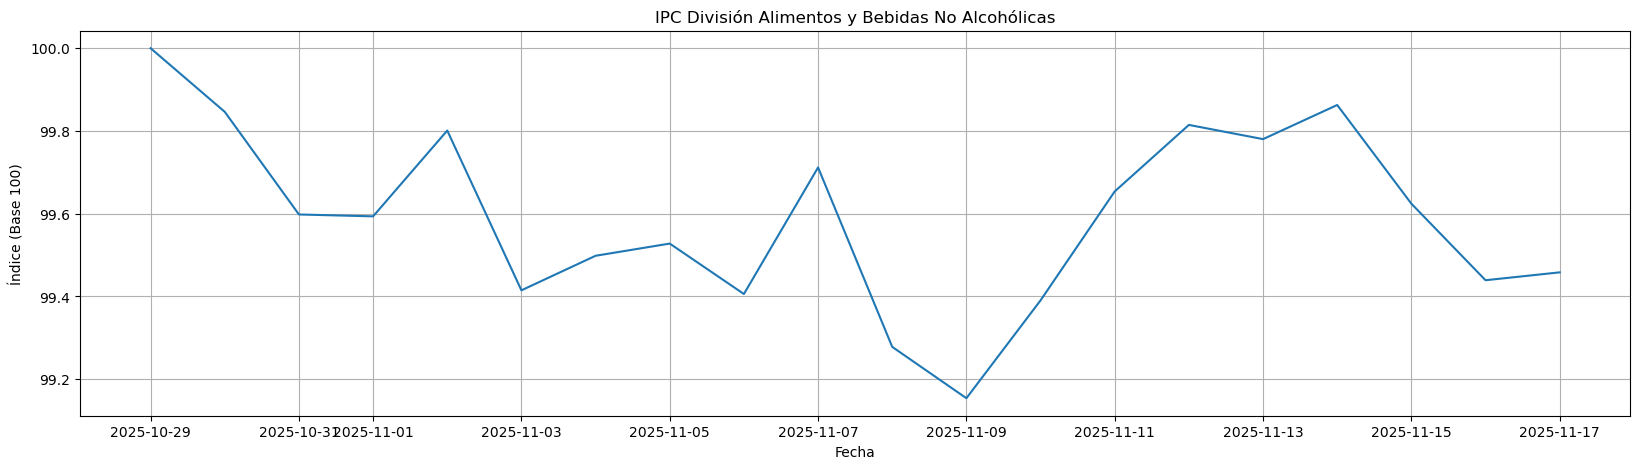

In [40]:
plt.figure(figsize=(20, 5))
plt.plot(ipc_alimentos.index, ipc_alimentos.values)
plt.title("IPC División Alimentos y Bebidas No Alcohólicas")
plt.xlabel("Fecha")
plt.ylabel("Índice (Base 100)")
plt.grid(True)
plt.show()

## EDUCACIÓN

In [41]:
dir_input = Path("data/base100/")
ipc_file = dir_input / "base_educacion.xlsx"

w_educacion = 8.058   # Peso total de la división Educación

In [42]:
df_ipc = pd.read_excel(ipc_file)
df_ipc.columns = df_ipc.columns.str.upper()

categorias = df_ipc["CATEGORIA"].tolist()

print("Categorías detectadas:")
for i, c in enumerate(categorias):
    print(i + 1, c)

Categorías detectadas:
1 INICIAL
2 PRIMARIA
3 SECUNDARIA


In [43]:
pesos_educacion = [
   0.691,
   1.553,
   1.259
]

In [44]:
# NORMALIZACIÓN 
suma_original = sum(pesos_educacion)
factor = w_educacion / suma_original
pesos_norm = [p * factor for p in pesos_educacion]

print("\nSuma original:", suma_original)
print("Suma normalizada:", sum(pesos_norm))

df_pesos = pd.DataFrame({
    "CATEGORIA": categorias,
    "PESO": pesos_educacion,
    "PESO_NORMALIZADO": pesos_norm
})

display(df_pesos)


Suma original: 3.5029999999999997
Suma normalizada: 8.058


,CATEGORIA,PESO,PESO_NORMALIZADO
0,INICIAL,0.691,1.589517
1,PRIMARIA,1.553,3.572388
2,SECUNDARIA,1.259,2.896095


In [45]:
cols_fechas = [c for c in df_ipc.columns if "2025" in c]

w = np.array(pesos_norm)

def geom_pond(x, w):
    x = np.array(x)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

ipc_educacion = {}

for col in cols_fechas:
    ipc_educacion[col] = geom_pond(df_ipc[col], w)

# Serie final ordenada por fecha
ipc_educacion = pd.Series(ipc_educacion)
ipc_educacion.index = pd.to_datetime(ipc_educacion.index)
ipc_educacion = ipc_educacion.sort_index()

print("\nIPC de la División EDUCACIÓN:")
display(ipc_educacion)


IPC de la División EDUCACIÓN:


C:\Users\jhers\AppData\Local\Temp\ipykernel_36556\2332664689.py:16: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ipc_educacion.index = pd.to_datetime(ipc_educacion.index)


2025-10-29    100.000000
2025-10-30    100.397105
2025-10-31     98.627955
2025-11-01    100.430539
2025-11-02    100.430539
2025-11-03    101.145175
2025-11-04    100.794497
2025-11-05    100.193337
2025-11-06     99.871606
2025-11-07     99.872030
2025-11-08    100.052648
2025-11-09    100.221975
2025-11-10    101.190780
2025-11-11    101.850849
2025-11-12    102.699353
2025-11-13    101.703461
2025-11-14    102.005332
2025-11-15    101.902635
2025-11-16    101.528588
2025-11-17    102.072201
2025-11-18    100.348139
2025-11-19    102.211123
dtype: float64

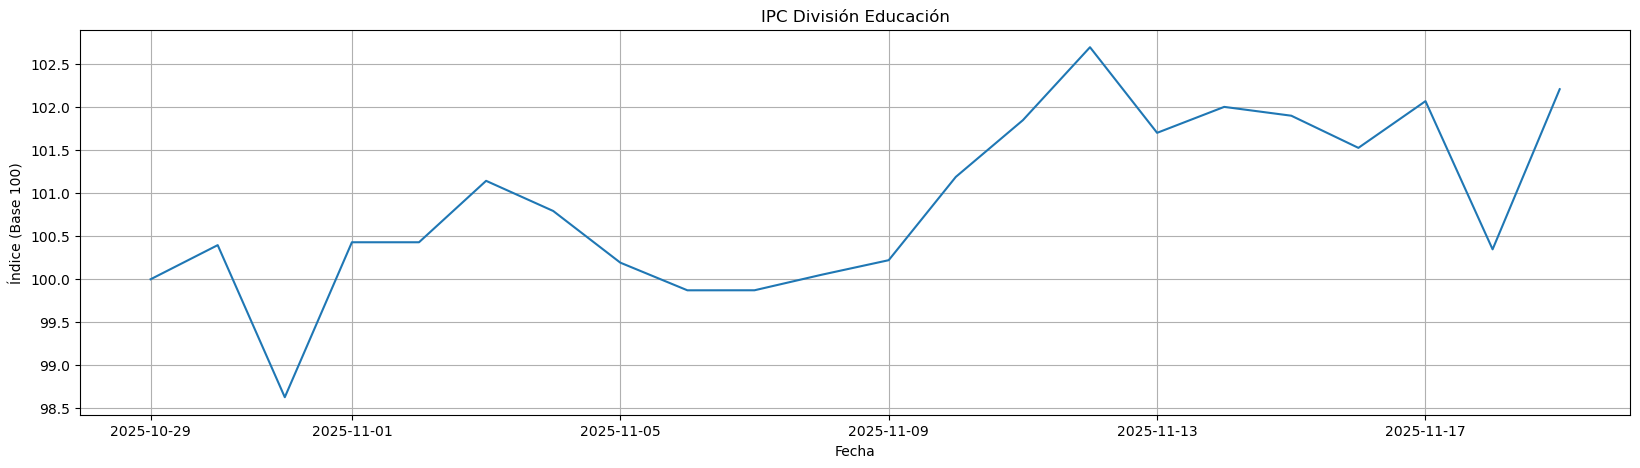

In [46]:
plt.figure(figsize=(20, 5))
plt.plot(ipc_educacion.index, ipc_educacion.values)
plt.title("IPC División Educación")
plt.xlabel("Fecha")
plt.ylabel("Índice (Base 100)")
plt.grid(True)
plt.show()

## TRANSPORTE

In [47]:
dir_input = Path("data/base100/")
ipc_file = dir_input / "base_transporte.xlsx"  

df_ipc = pd.read_excel(ipc_file)
df_ipc.columns = df_ipc.columns.astype(str)

In [48]:
fecha_cols = []
for c in df_ipc.columns:
    if "2025" in c:
        limpio = c.split(" ")[0]       # quita hora
        fecha_cols.append(limpio)
    else:
        fecha_cols.append(c)

df_ipc.columns = fecha_cols

print("Encabezados limpios:")
print(df_ipc.columns.tolist())

Encabezados limpios:
['CATEGORIA', '2025-10-29', '2025-10-30', '2025-10-31', '2025-11-01', '2025-11-02', '2025-11-03', '2025-11-04', '2025-11-05', '2025-11-06', '2025-11-07', '2025-11-08', '2025-11-09', '2025-11-10', '2025-11-11', '2025-11-12', '2025-11-13', '2025-11-14', '2025-11-15', '2025-11-16', '2025-11-17', '2025-11-18', '2025-11-19']


In [49]:
# PESOS – TRANSPORTE
CATEGORIA = df_ipc["CATEGORIA"].tolist()

pesos_transporte = [
    12.210 
]

w_transporte = 12.210  # peso oficial de la división

suma_original = sum(pesos_transporte)
factor = w_transporte / suma_original
pesos_norm = [p * factor for p in pesos_transporte]

print("\nSuma original:", suma_original)
print("Suma normalizada:", sum(pesos_norm))

w = np.array(pesos_norm)


Suma original: 12.21
Suma normalizada: 12.21


In [50]:
cols_2025 = [c for c in df_ipc.columns if c != "CATEGORIA"]

def geom_pond(x, w):
    x = np.array(x, dtype=float)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

ipc_transporte = {}

for col in cols_2025:
    ipc_transporte[col] = geom_pond(df_ipc[col], w)

# Convertir a serie ordenada
ipc_transporte = pd.Series(ipc_transporte)
ipc_transporte.index = pd.to_datetime(ipc_transporte.index)
ipc_transporte = ipc_transporte.sort_index()

print("\nIPC Transporte:")
display(ipc_transporte)


IPC Transporte:


2025-10-29    100.000000
2025-10-30     99.949285
2025-10-31     99.773640
2025-11-01     99.785960
2025-11-02     99.782047
2025-11-03     99.716436
2025-11-04     99.697225
2025-11-05     99.982280
2025-11-06     99.810972
2025-11-07     99.682094
2025-11-08     99.638337
2025-11-09     99.616004
2025-11-10     99.564996
2025-11-11     99.582151
2025-11-12     99.588788
2025-11-13     99.879165
2025-11-14     99.616921
2025-11-15     99.675911
2025-11-16     99.694290
2025-11-17     99.692003
2025-11-18     99.723232
2025-11-19     99.734836
dtype: float64

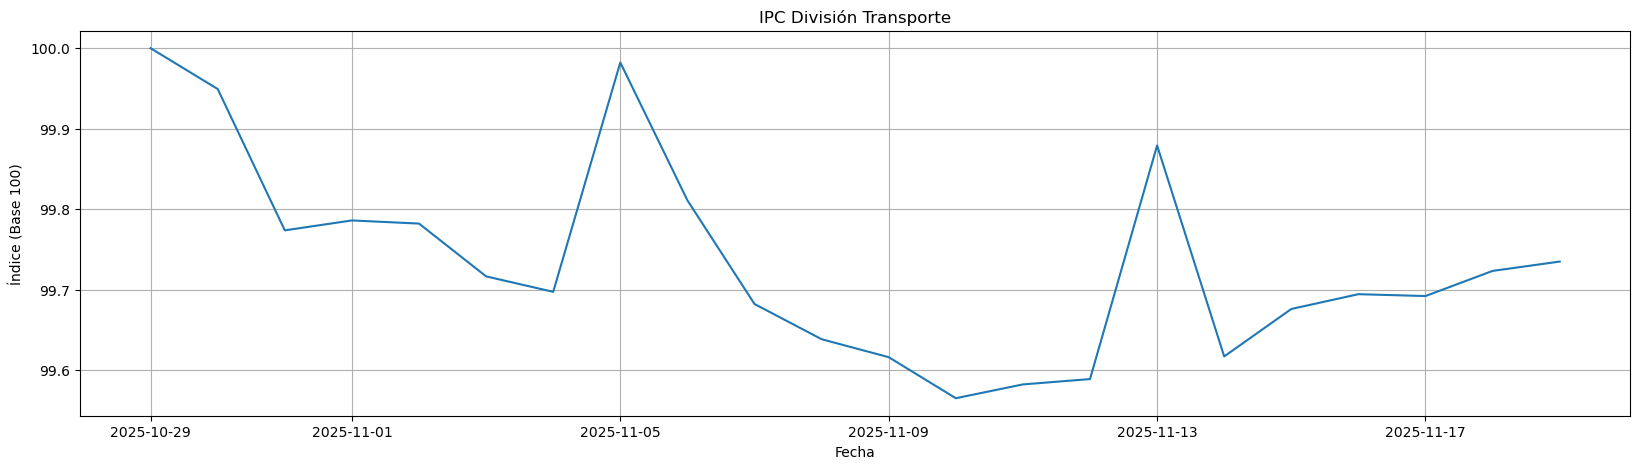

In [51]:
plt.figure(figsize=(20, 5))
plt.plot(ipc_transporte.index, ipc_transporte.values)
plt.title("IPC División Transporte")
plt.xlabel("Fecha")
plt.ylabel("Índice (Base 100)")
plt.grid(True)
plt.show()

## VIVIENDA


In [52]:
dir_input = Path("data/base100/")
ipc_file = dir_input / "base_vivienda.xlsx"  

df_ipc = pd.read_excel(ipc_file)
df_ipc.columns = df_ipc.columns.astype(str)

In [53]:
fecha_cols = []
for c in df_ipc.columns:
    if "2025" in c:
        limpio = c.split(" ")[0]       # quita hora
        fecha_cols.append(limpio)
    else:
        fecha_cols.append(c)

df_ipc.columns = fecha_cols

print("Encabezados limpios:")
print(df_ipc.columns.tolist())

Encabezados limpios:
['Tipo', '2025-10-26', '2025-10-27', '2025-10-28', '2025-10-29', '2025-10-30', '2025-10-31', '2025-11-01', '2025-11-02', '2025-11-03', '2025-11-04', '2025-11-05', '2025-11-06', '2025-11-07', '2025-11-08', '2025-11-09', '2025-11-10', '2025-11-11', '2025-11-12', '2025-11-13', '2025-11-14', '2025-11-15', '2025-11-16']


In [54]:
# PESOS – ALOJAMIENTO
Tipo = df_ipc["Tipo"].tolist()

pesos_alojamiento = [
    4.451,
    0.000
]

w_alojamiento = 9.607  # peso oficial de la división

suma_original = sum(pesos_alojamiento)
factor = w_alojamiento / suma_original
pesos_norm = [p * factor for p in pesos_alojamiento]

print("\nSuma original:", suma_original)
print("Suma normalizada:", sum(pesos_norm))

w = np.array(pesos_norm)


Suma original: 4.451
Suma normalizada: 9.607


In [55]:
cols_2025 = [c for c in df_ipc.columns if c != "Tipo"]

def geom_pond(x, w):
    x = np.array(x, dtype=float)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

ipc_alojamiento = {}

for col in cols_2025:
    ipc_alojamiento[col] = geom_pond(df_ipc[col], w)

# Convertir a serie ordenada
ipc_alojamiento = pd.Series(ipc_alojamiento)
ipc_alojamiento.index = pd.to_datetime(ipc_alojamiento.index)
ipc_alojamiento = ipc_alojamiento.sort_index()

print("\nIPC División Alojamiento, Agua, Electricidad, Gas y Otros Combustibles:")
display(ipc_alojamiento)


IPC División Alojamiento, Agua, Electricidad, Gas y Otros Combustibles:


2025-10-26    109.699939
2025-10-27     93.406656
2025-10-28    101.692334
2025-10-29    100.000000
2025-10-30     94.944633
2025-10-31    101.313594
2025-11-01    133.855752
2025-11-02    105.221224
2025-11-03     97.175199
2025-11-04     99.413220
2025-11-05    104.362623
2025-11-06    132.373978
2025-11-07     93.414796
2025-11-08    118.081414
2025-11-09    100.681859
2025-11-10     88.544369
2025-11-11    104.658181
2025-11-12    100.775353
2025-11-13    106.473833
2025-11-14    100.633805
2025-11-15     96.249844
2025-11-16    101.548920
dtype: float64

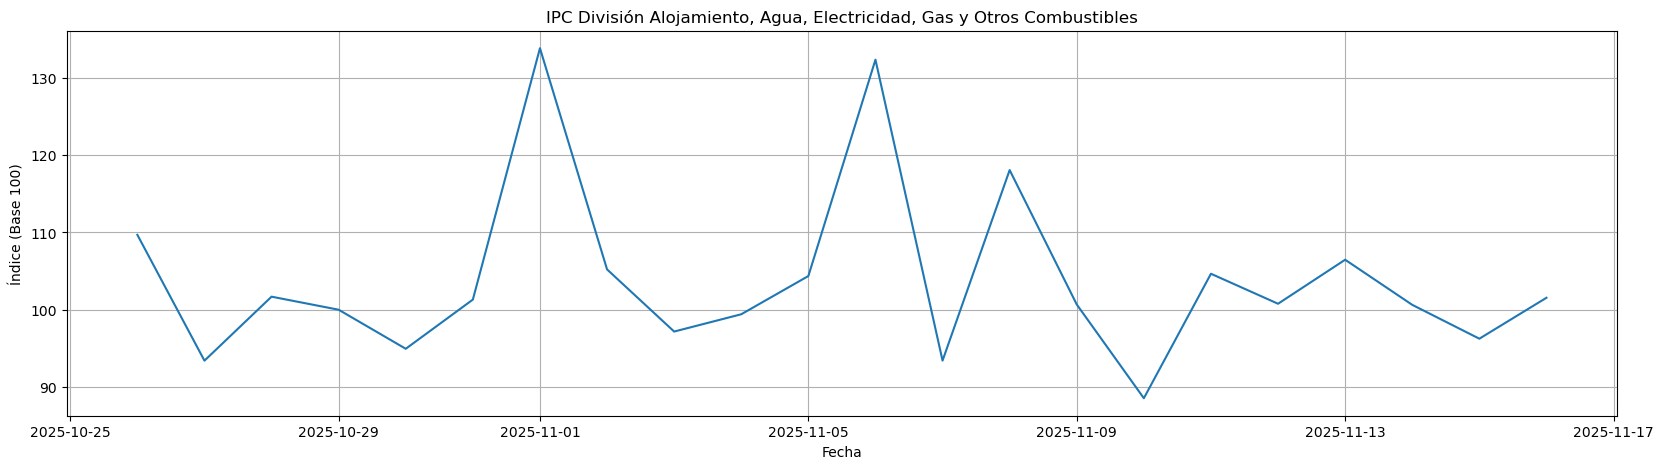

In [56]:
plt.figure(figsize=(20, 5))
plt.plot(ipc_alojamiento.index, ipc_alojamiento.values)
plt.title("IPC División Alojamiento, Agua, Electricidad, Gas y Otros Combustibles")
plt.xlabel("Fecha")
plt.ylabel("Índice (Base 100)")
plt.grid(True)
plt.show()

## ÍNDICE FINAL

In [60]:
# Pesos oficiales de cada división 
pesos_div = {
    "ALIMENTOS": 23.928,
    "SALUD": 3.475,
    "EDUCACION": 8.058,
    "TRANSPORTE": 12.210,
    "ALOJAMIENTO": 9.607
}

# Suma total oficial
suma_total = sum(pesos_div.values())

# Normalización para que sumen 100
factor = 100 / suma_total

pesos_div_norm = {k: v * factor for k, v in pesos_div.items()}

print("\nPESOS NORMALIZADOS:")
for k, v in pesos_div_norm.items():
    print(f"{k}: {v:.4f}")

# Convertir a vector en el mismo orden
divisiones = ["ALIMENTOS", "SALUD", "EDUCACION", "TRANSPORTE", "ALOJAMIENTO"]
w = np.array([pesos_div_norm[d] for d in divisiones])
w = w / w.sum()   # por si acaso

print("\nVector de pesos final usado para el IPC total:")
print(w)



PESOS NORMALIZADOS:
ALIMENTOS: 41.7752
SALUD: 6.0669
EDUCACION: 14.0682
TRANSPORTE: 21.3171
ALOJAMIENTO: 16.7726

Vector de pesos final usado para el IPC total:
[0.41775202 0.06066902 0.14068229 0.21317085 0.16772583]


In [61]:
ipc_divisiones = pd.DataFrame({
    "ALIMENTOS": ipc_alimentos,
    "SALUD": ipc_salud,
    "EDUCACION": ipc_educacion,
    "TRANSPORTE": ipc_transporte,
    "ALOJAMIENTO": ipc_alojamiento
})

# Asegurar orden correcto
ipc_divisiones = ipc_divisiones[divisiones]

# Función media geométrica ponderada
def geom_pond(x, w):
    x = np.array(x)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

ipc_total = {}

for fecha in ipc_divisiones.index:
    valores = ipc_divisiones.loc[fecha].values
    ipc_total[fecha] = geom_pond(valores, w)

ipc_total = pd.Series(ipc_total)
ipc_total = ipc_total.sort_index()

print("\nIPC TOTAL:")
display(ipc_total)


IPC TOTAL:


2025-10-26           NaN
2025-10-27           NaN
2025-10-28           NaN
2025-10-29    100.000000
2025-10-30     99.111501
2025-10-31     99.805144
2025-11-01    104.881875
2025-11-02    100.818738
2025-11-03     99.360454
2025-11-04     99.718813
2025-11-05    100.512423
2025-11-06    104.476853
2025-11-07     98.629680
2025-11-08    102.446153
2025-11-09     99.710193
2025-11-10     97.802411
2025-11-11    100.792742
2025-11-12    100.332553
2025-11-13    101.180731
2025-11-14    100.247472
2025-11-15     99.400455
2025-11-16    100.198856
2025-11-17           NaN
2025-11-18           NaN
2025-11-19           NaN
dtype: float64

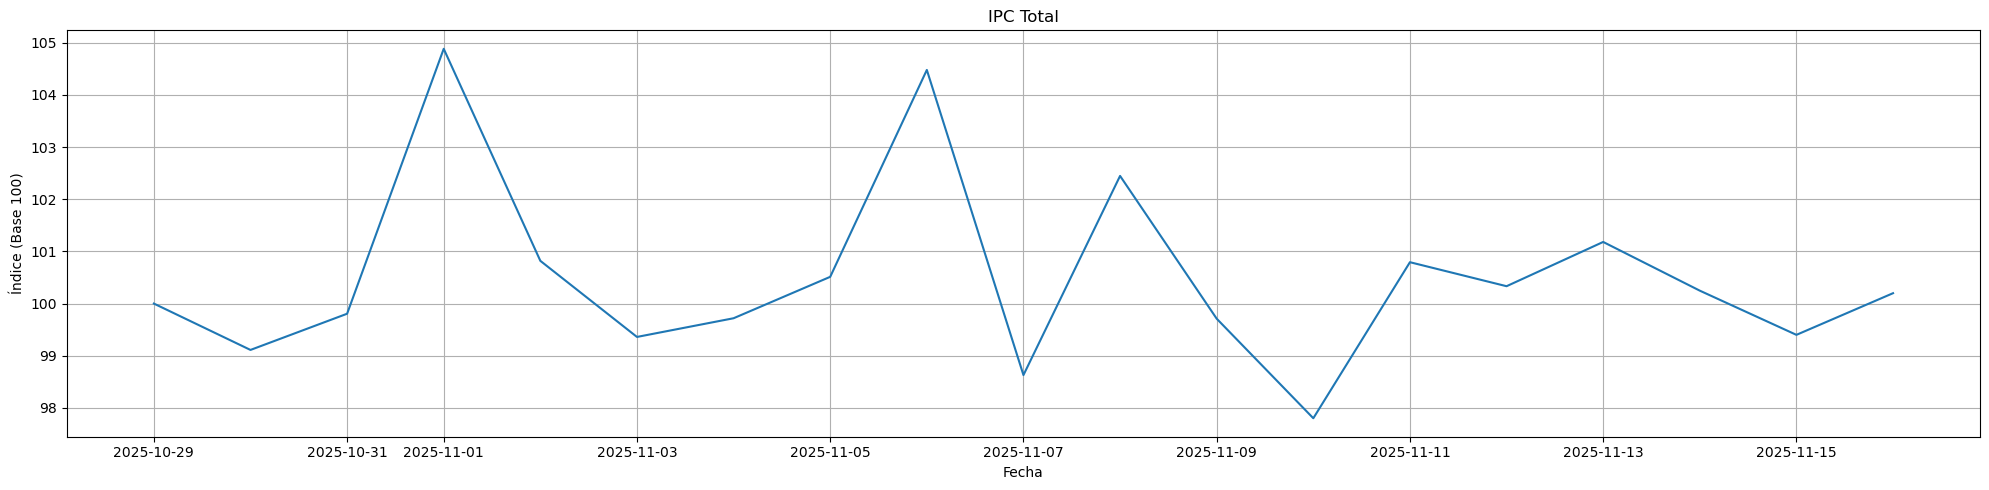

In [62]:

plt.figure(figsize=(20, 5))
plt.plot(ipc_total.index, ipc_total.values)
plt.title("IPC Total")
plt.xlabel("Fecha")
plt.ylabel("Índice (Base 100)")
plt.grid(True)
plt.tight_layout()
plt.show()